In [1]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
import numpy as np
import cv2
#from dataset import load_hoda

Using TensorFlow backend.


In [2]:
np.random.seed(100)  # for reproducibility

In [3]:
from scipy import io

PATH = './dataset/Data_hoda_full.mat'

def load_hoda(training_sample_size=50000, test_sample_size=10000, size=9, dataset_path=PATH):
    #load dataset
    trs = training_sample_size
    tes = test_sample_size
    dataset = io.loadmat(dataset_path)

    #test and training set
    X_train_orginal = np.squeeze(dataset['Data'][:trs])
    y_train = np.squeeze(dataset['labels'][:trs])
    X_test_original = np.squeeze(dataset['Data'][trs:trs+tes])
    y_test = np.squeeze(dataset['labels'][trs:trs+tes])

    #resize
    X_train_9by9 = [cv2.resize(img, dsize=(size, size)) for img in X_train_orginal]
    X_test_9by_9 = [cv2.resize(img, dsize=(size, size)) for img in X_test_original]
    
    #add Padding
    old_size = (size, size)
    list_X_train = []
    list_X_test = []
    for i in X_train_9by9:
        paded = np.zeros((old_size[0] + 20, old_size[1] + 20), np.uint8)
        for x in range(10, old_size[0] + 10):
            for y in range(10, old_size[1] + 10):
                paded[x][y] = i[x - 10][y - 10]
        list_X_train.append(paded)

    for i in X_test_9by_9:
        paded = np.zeros((old_size[0] + 20, old_size[1] + 20), np.uint8)
        for x in range(10, old_size[0] + 10):
            for y in range(10, old_size[1] + 10):
                paded[x][y] = i[x - 10][y - 10]
        list_X_test.append(paded)

    
    X_train = np.array(list_X_train)
    X_test = np.array(list_X_test)
    #reshape
    #X_train_paded = [x.reshape(29*29) for x in X_train]
    #X_test_paded = [x.reshape(29*29) for x in X_test]
    
    return X_train, y_train, X_test, y_test

In [4]:
# Load pre-shuffled HODA data into train and test sets
x_train_original, y_train_original, x_test_original, y_test_original = load_hoda(
                                                                        training_sample_size=50000,
                                                                        test_sample_size=10000,size=28)

In [5]:
# Preprocess input data
''' 3.1: input data in numpy array format'''
x_train = np.array(x_train_original)
x_test = np.array(x_test_original)
'''3.2 normalize our data values to the range [0, 1]'''
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
x_train.shape

(50000, 48, 48)

In [8]:
# Reshape to original image shape (n x 784)  ==> (n x 28 x 28 x 1)
x_train = x_train.reshape(-1,48,48,1)
x_test = x_test.reshape(-1,48,48,1)

In [9]:
# 4. Preprocess class labels
y_train = keras.utils.to_categorical(y_train_original, num_classes=10)
y_test = keras.utils.to_categorical(y_test_original, num_classes=10)

In [10]:
# test and validation set
x_val = x_test[5000:]
x_test = x_test[:5000]
y_val = y_test[5000:]
y_test = y_test[:5000]

In [15]:
# 5. Define model architecture
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

In [17]:
# 6. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#loading model
from keras.models import load_model
model = load_model("cnn_model_padded.h5")

In [18]:
# 7. Fit model on training data
history = model.fit(x_train, y_train,
          epochs=30, batch_size=256, validation_data = (x_val, y_val))

Train on 50000 samples, validate on 5000 samples
Epoch 1/30
50000/50000 [==============================] - 14s 285us/step - loss: 0.1945 - acc: 0.9387 - val_loss: 0.0390 - val_acc: 0.9876
Epoch 2/30
50000/50000 [==============================] - 12s 238us/step - loss: 0.0596 - acc: 0.9830 - val_loss: 0.0176 - val_acc: 0.9946
Epoch 3/30
50000/50000 [==============================] - 12s 238us/step - loss: 0.0446 - acc: 0.9866 - val_loss: 0.0258 - val_acc: 0.9914
Epoch 4/30
50000/50000 [==============================] - 12s 238us/step - loss: 0.0354 - acc: 0.9890 - val_loss: 0.0176 - val_acc: 0.9950
Epoch 5/30
50000/50000 [==============================] - 12s 239us/step - loss: 0.0277 - acc: 0.9913 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 6/30
50000/50000 [==============================] - 12s 237us/step - loss: 0.0244 - acc: 0.9923 - val_loss: 0.0093 - val_acc: 0.9978
Epoch 7/30
50000/50000 [==============================] - 12s 237us/step - loss: 0.0216 - acc: 0.9930 - val_loss: 0.0

In [19]:
# 7. Test the model on test data
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.013390782042655905
Test accuracy: 0.9968


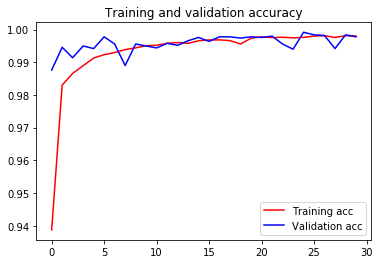

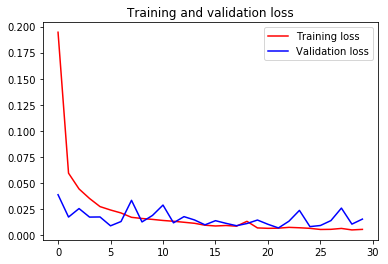

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
#save model
model.save("cnn_model_padded.h5")

In [24]:
def preprocess(img, size=28):
    #resize
    img_9by9 = cv2.resize(img, dsize=(size, size))
    #normalize
    np_img = np.array(img_9by9)
    np_img = np_img.reshape((1,48,48,1))
    np_img = np_img.astype('float32')
    np_img /= 255
    
    return np_img

In [25]:
# test the model other handwritten digit
test = cv2.imread("digit31.jpg")
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
cv2.imshow("digit", thresh)
cv2.waitKey()
cv2.destroyAllWindows()

test_sample = preprocess(thresh)
predicted_class = model.predict_classes([test_sample])
print(predicted_class)

ValueError: cannot reshape array of size 784 into shape (1,48,48,1)